In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 5]
plt.rcParams['axes.grid'] = True
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
font = {'family' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
pd.set_option('display.max_rows', 200)
pd.set_option('precision', 4)

# modeling 
import lightgbm as lgb
import autofeat

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Load data
data = pd.read_csv('../dataset/processed_data.csv', index_col=0)
data.rename({'default.payment.next.month': 'default'}, axis=1, inplace=True)
data.default = data.default.astype(bool)

In [3]:
TEST_SIZE = 0.10

KFOLDS = 5 #number of KFolds for cross-validation
SEED = 7

TARGET = 'default'

# Part 2 - Training Models

In the previous notebook we achieved the following metrics using a simple LGBTClassifier without any hyperparameter tuning and using 5 folds in our cross validation.

              precision    recall  f1-score   support

       False       0.86      0.92      0.89       776
        True       0.63      0.49      0.55       224

    accuracy                           0.82      1000
    macro avg      0.75      0.70      0.72      1000
    weighted avg   0.81      0.82      0.81      1000

ROC AUC Score:  `0.702`

In this notebook we'll tune the GBT and then form an ensemble with other models.
The best model will be selected for production

In [4]:
predictions = {}

#  Train/Test Splits

Because all the engineered features are generated from a single sample, there is no leaking of data into
the test set.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data.drop('default', axis=1),
                                                data['default'], 
                                                test_size = TEST_SIZE, 
                                                stratify=data['default'],
                                                random_state = SEED,
                                                shuffle=True)

In [7]:
def score(y_pred, ytest=ytest):
    cm = confusion_matrix(y_true = ytest, y_pred=y_pred)
    cmatrix = pd.DataFrame(data=cm, index=['Actual Non-Default', 'Actual Default'], 
                                     columns=['Predict Non-Default', 'Predict Default'])
    plt.figure(figsize=(10, 3))
    sns.heatmap(cmatrix, cmap='Blues', annot=True, fmt='d');
    print(classification_report(ytest, y_pred))
    print("ROC AUC Score: ", roc_auc_score(ytest, y_pred, average='weighted'))

# Model Building

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tpot import TPOTClassifier

In [98]:
# These hyperparameters are standard kaggle recommended ones.
tpot = TPOTClassifier(verbosity=2, 
                      max_time_mins=5, 
                      cv=5,
                      max_eval_time_mins=0.04, 
                      population_size=50,
                      generations=6)
tpot.fit(xtrain, ytrain)
y_pred = tpot.predict(xtest)


Generation 1 - Current best internal CV score: 0.8035555555555556

Generation 2 - Current best internal CV score: 0.8161111111111111

Generation 3 - Current best internal CV score: 0.8161111111111111

5.02 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: KNeighborsClassifier(SelectPercentile(input_matrix, percentile=1), n_neighbors=95, p=1, weights=distance)


              precision    recall  f1-score   support

       False       0.83      0.96      0.89       776
        True       0.71      0.31      0.43       224

    accuracy                           0.82      1000
   macro avg       0.77      0.64      0.66      1000
weighted avg       0.80      0.82      0.79      1000

ROC AUC Score:  0.6359766200294552


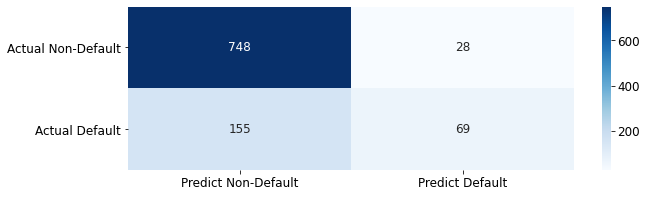

In [99]:
score(y_pred)

For some reason, TPOT is not able to learn as well as LGBMClassifier so we won't add it to our predictions set.

## LGBM Feature Selection

In [9]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import gc

In [10]:
def kfold_lightgbm(data, num_folds=5, stratified = True, debug= False, test_size=0.1):
    xtrain, xtest, ytrain, ytest = train_test_split(
                                                data.drop('default', axis=1),
                                                data['default'], 
                                                test_size = test_size, 
                                                stratify=data['default'],
                                                random_state = 8,
                                                shuffle=True)
    
    # Divide in training/validation and test data
    folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(xtrain.shape[0])
    sub_preds = np.zeros(xtest.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = xtrain.columns
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(xtrain, ytrain)):
        train_x, train_y = xtrain.iloc[train_idx], ytrain.iloc[train_idx]
        valid_x, valid_y = xtrain.iloc[valid_idx], ytrain.iloc[valid_idx]

        clf = LGBMClassifier(
            n_estimators=2000,
            learning_rate=0.1,
            num_leaves=123,
            colsample_bytree=.8,
            subsample=.9,
            max_depth=15,
            reg_alpha=.1,
            reg_lambda=.1,
            min_split_gain=.01,
            min_child_weight=2,
            nthread=4,
            is_unbalance=True
        )

        clf.fit(train_x, train_y, 
                eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc', 
                verbose= 1000, 
                early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(xtest, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()
        
    y_preds = sub_preds > 0.5
    score(y_preds, ytest)
    return clf

[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[18]	training's auc: 0.959041	training's binary_logloss: 0.328353	valid_1's auc: 0.771994	valid_1's binary_logloss: 0.472995
Fold  1 AUC : 0.771994
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[11]	training's auc: 0.940046	training's binary_logloss: 0.371802	valid_1's auc: 0.772789	valid_1's binary_logloss: 0.469641
Fold  2 AUC : 0.772789
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[8]	training's auc: 0.93578	training's binary_logloss: 0

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Early stopping, best iteration is:
[8]	training's auc: 0.9334	training's binary_logloss: 0.391334	valid_1's auc: 0.747014	valid_1's binary_logloss: 0.482511
Fold  5 AUC : 0.747014
              precision    recall  f1-score   support

       False       0.86      0.92      0.89       776
        True       0.64      0.50      0.56       224

    accuracy                           0.82      1000
   macro avg       0.75      0.71      0.73      1000
weighted avg       0.81      0.82      0.82      1000

ROC AUC Score:  0.7087628865979382


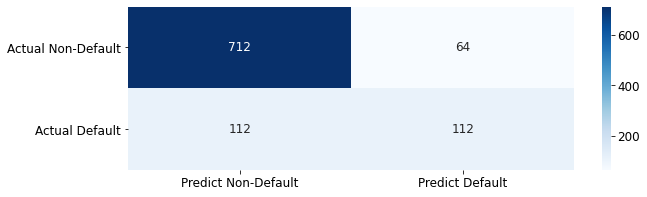

In [11]:
clf = kfold_lightgbm(data);

In [12]:
# This is the best so far, so we add it to the list
predictions['lgbm'] = np.array(list(zip(*clf.predict_proba(xtest)))[1])

### LGBM Round Two
We now try to find the best hyperparameters for our model.

In [13]:
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)

In [14]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_test ={'n_estimators': [1000, 2000, 3000, 4000, 5000],
             'num_leaves': [10, 50, 100, 150, 200], 
             'max_depth': [5, 10, 15, 20],
             'min_child_samples': sp_randint(100, 500), 
             'subsample': [0.5, 0.75, 0.9, 1.0, 1.2], 
             'colsample_bytree': [0.4, 0.6, 0.8, 1],
             'reg_alpha': [0, 0.05, 0.1, 0.5, 1, 2, 5, 7],
             'reg_lambda': [0, 0.05, 0.1, 0.5, 1, 2, 5, 7],
             'min_split_gain': [0.005, 0.01, 0.05, 0.1],
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            }

In [15]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [16]:
import lightgbm as lgb
def lgbmtuning(data, num_folds=5, stratified = True, debug= False, test_size=0.1):
    n_HP_points_to_test = 100
    xtrain, xtest, ytrain, ytest = train_test_split(
                                                data.drop('default', axis=1),
                                                data['default'], 
                                                test_size = test_size, 
                                                stratify=data['default'],
                                                random_state = 8,
                                                shuffle=True)
    
    xtrain, xval, ytrain, yval = train_test_split(
                                                xtrain,
                                                ytrain, 
                                                test_size = test_size, 
                                                stratify=ytrain,
                                                random_state = 8,
                                                shuffle=True)
    
    fit_params={"early_stopping_rounds":30, 
                "eval_metric" : 'auc', 
                "eval_set" : [(xval, yval)],
                'eval_names': ['valid'],
                'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
                'verbose': False,
                'categorical_feature': 'auto'}

    clf = lgb.LGBMClassifier(max_depth=-1, 
                             random_state=314, 
                             silent=True, 
                             metric='None', 
                             is_unbalance=True,
                             n_jobs=7, 
                             n_estimators=5000)
    
    gs = RandomizedSearchCV(
        estimator=clf, param_distributions=param_test, 
        n_iter=n_HP_points_to_test,
        scoring='roc_auc',
        cv=num_folds,
        refit=True,
        random_state=314,
        verbose=True)
    
    gs.fit(xtrain, ytrain, **fit_params)
    print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_}')
    y_preds = gs.predict(xtest)
    score(y_preds, ytest)
    return gs

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   45.5s finished


Best score reached: 0.7735526777792538 with params: {'colsample_bytree': 0.6, 'max_depth': 10, 'min_child_samples': 108, 'min_child_weight': 1e-05, 'min_split_gain': 0.1, 'n_estimators': 4000, 'num_leaves': 200, 'reg_alpha': 0.05, 'reg_lambda': 2, 'subsample': 0.75}
              precision    recall  f1-score   support

       False       0.88      0.83      0.86       776
        True       0.51      0.61      0.56       224

    accuracy                           0.78      1000
   macro avg       0.70      0.72      0.71      1000
weighted avg       0.80      0.78      0.79      1000

ROC AUC Score:  0.7204528718703976


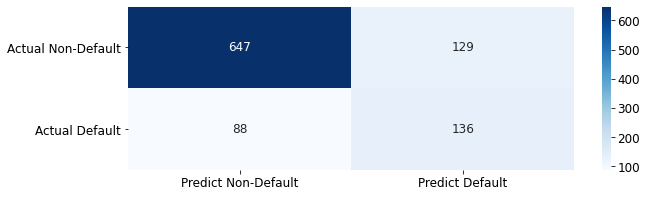

In [17]:
gs = lgbmtuning(data)

Because we chose to optimize `auc`, we actually traded off some accuracy. We'll add it to the mix.

In [21]:
predictions['lgbm_opt'] = np.array(list(zip(*gs.predict_proba(xtest)))[1])

              precision    recall  f1-score   support

       False       0.89      0.90      0.90       776
        True       0.65      0.60      0.62       224

    accuracy                           0.84      1000
   macro avg       0.77      0.75      0.76      1000
weighted avg       0.83      0.84      0.83      1000

ROC AUC Score:  0.7536588733431516


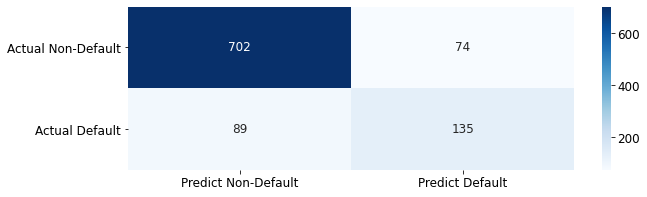

In [39]:
concat = pd.concat([((pd.DataFrame(predictions)).mean(axis=1)>0.5), ytest.reset_index(drop=True)], axis=1)
score(concat[0])

In [293]:
import lime
from lime.lime_tabular import LimeTabularExplainer


In [361]:
class CreditDefaultPredictor:
    def __init__(self, acc_model, auc_model, data):
        self.acc_model = acc_model
        self.auc_model = auc_model
        self.fit_explainer(data)
        
    def fit_explainer(self, data):
        self.explainer = LimeTabularExplainer(
            training_data=np.array(data.drop('default', axis=1)),
            mode='classification', 
            feature_names=list(data.drop('default', axis=1).columns),
            training_labels=np.array(data['default']),
            random_state=12)
        
    def predict_proba(self, sample):
        """ Must be fed a dictionary
        """
        if type(sample) != dict:
            raise ValueError("Sample must be a dict of features.")
        sample = pd.DataFrame(sample, index=range(1))
        probs = {}
        probs['acc'] = self.acc_model.predict_proba(sample)[0][0]
        probs['auc'] = self.auc_model.predict_proba(sample)[0][0]
        return pd.Series(probs)
    
    def predict(self, sample, engineer_features=False):
        if engineer_features:
            sample = dict(self.engineer_features(sample).iloc[0])
        probs = self.predict_proba(sample)
        return probs.mean() > 0.5
    
    def predict_proba_many_from_df(self, samples):
        predictions = {
            'acc': np.array(list(zip(*self.acc_model.predict_proba(samples)))[1]),
            'auc': np.array(list(zip(*self.auc_model.predict_proba(samples)))[1])
        }
        return predictions
    
    def predict_many_from_df(self, samples):
        probs = self.predict_proba_many_from_df(samples)
        return pd.DataFrame(predictions).mean(axis=1)>0.5
    
    def explain_prediction(self, sample, engineer_features=False):
        if engineer_features:
            sample = dict(self.engineer_features(sample).iloc[0])
        sample = pd.Series(sample)
        exp = self.explainer.explain_instance(sample, 
                                        self.predict_proba_explainer,
                                        num_features=8)
        exp.show_in_notebook(show_table=True, show_all=True)
        
    def predict_proba_explainer(self, sample):
        return (self.acc_model.predict_proba(sample) +
                self.auc_model.predict_proba(sample)) / 2
    
    def engineer_features(self, sample):
        if 'ID' in sample.keys():
            del sample['ID']
        if 'default.payment.next.month' in sample.keys():
            del sample['default.payment.next.month']
            
        sample = pd.DataFrame(sample, index=range(1))
        sample['EDUCATION'] = sample['EDUCATION'].replace(5, 4).replace(6, 4).replace(0, 4)
        sample['MARRIAGE'] = sample['MARRIAGE'].replace(0, 3)
        
        sample['MAX_PAY'] = sample.filter(like='PAY_AMT').max(axis=1)
        sample['MIN_PAY'] = sample.filter(like='PAY_AMT').min(axis=1)
        sample['AVE_PAY'] = sample.filter(like='PAY_AMT').mean(axis=1)
        sample['STD_PAY'] = sample.filter(like='PAY_AMT').std(axis=1)

        sample['MAX_BILL'] = sample.filter(like='BILL').max(axis=1)
        sample['MIN_BILL'] = sample.filter(like='BILL').min(axis=1)
        sample['AVE_BILL'] = sample.filter(like='BILL').mean(axis=1)
        sample['STD_BILL'] = sample.filter(like='BILL').std(axis=1)

        sample['NEVER_USED'] = (sample.filter(regex='PAY_[0, 2-9]')==-2).all(axis=1).astype(int)
        sample['MONTHS_UNUSED'] = (sample.filter(regex='PAY_[1-9]')==-2).sum(axis=1).astype(int)

        sample['NUM_LIMIT_BAL_BREACH'] = (sample.filter(like='BILL_AM')
                                             .gt(sample['LIMIT_BAL'], axis=0)).sum(axis=1)

        sample['NUM_PAID_EARLY'] = sample.filter(like='BILL_AMT').lt(0, axis=0).sum(axis=1)

        sample['AMOUNT_BREACHED_5'] = (sample['BILL_AMT5'] - (sample['BILL_AMT6'] - sample['PAY_AMT5'])) / sample['LIMIT_BAL']
        sample['AMOUNT_BREACHED_4'] = (sample['BILL_AMT4'] - (sample['BILL_AMT5'] - sample['PAY_AMT4'])) / sample['LIMIT_BAL']
        sample['AMOUNT_BREACHED_3'] = (sample['BILL_AMT3'] - (sample['BILL_AMT4'] - sample['PAY_AMT3'])) / sample['LIMIT_BAL']
        sample['AMOUNT_BREACHED_2'] = (sample['BILL_AMT2'] - (sample['BILL_AMT3'] - sample['PAY_AMT2'])) / sample['LIMIT_BAL']
        sample['AMOUNT_BREACHED_1'] = (sample['BILL_AMT1'] - (sample['BILL_AMT2'] - sample['PAY_AMT1'])) / sample['LIMIT_BAL']

        sample['BREACH_AVE'] = sample.filter(like='AMOUNT_BREACHED').mean(axis=1)
        sample['BREACH_MAX'] = sample.filter(like='AMOUNT_BREACHED').max(axis=1)
        sample['BREACH_MIN'] = sample.filter(like='AMOUNT_BREACHED').min(axis=1)
        sample['BREACH_STD'] = sample.filter(like='AMOUNT_BREACHED').std(axis=1)

        # Because larger PAY_ numbers indicate larger delay, we penalize a client based on
        # how much they owe, and when they pay it.
        sample['DELAY_PENALTY_1'] = sample['PAY_0'] * sample['BILL_AMT1']
        sample['DELAY_PENALTY_2'] = sample['PAY_2'] * sample['BILL_AMT2']
        sample['DELAY_PENALTY_3'] = sample['PAY_3'] * sample['BILL_AMT3']
        sample['DELAY_PENALTY_4'] = sample['PAY_4'] * sample['BILL_AMT4']
        sample['DELAY_PENALTY_5'] = sample['PAY_5'] * sample['BILL_AMT5']
        sample['DELAY_PENALTY_6'] = sample['PAY_6'] * sample['BILL_AMT6']
        
        # Convert all negative bills to 0.
        x = sample.filter(like='BILL')
        x = x.where(x > 0, 0)
        sample.loc[:, sample.filter(like='BILL').columns] = x
        
        ## Box Cox Transformation
        lmbd = 0.2 
        for col in sample.filter(like='AMT').columns:
            sample[col] = (sample[col]+1.0).apply(lambda x: (x**lmbd-1)/lmbd )
            
        # One Hot Encoding - Must add the pre-existing values..
        sample['SEX'] = sample['SEX'].map({1:"male", 2:'female'})
        sample['EDUCATION'] = sample['EDUCATION'].map({1:'grad_school', 
                                                   2:'university', 
                                                   3:'high_school', 
                                                   4:'others', 
                                                   5:'others', 
                                                   6:'others'})
        sample['MARRIAGE'] = sample['MARRIAGE'].map({1:'married', 2:'single', 3:'other'})
        categorical = pd.get_dummies(sample[['SEX', 'EDUCATION', 'MARRIAGE']])
        sample = pd.concat([sample.drop(['MARRIAGE', 'SEX', 'EDUCATION'], axis=1), categorical], axis=1)
        for i in ['SEX_male', 'SEX_female', 'EDUCATION_grad_school', 
                  'EDUCATION_university', 'EDUCATION_high_school', 'EDUCATION_others',
                 'MARRIAGE_married', 'MARRIAGE_single', 'MARRIAGE_other']:
            if i not in sample.columns:
                sample[i] = 0
        return sample

In [362]:
predictor = CreditDefaultPredictor(clf, gs, data)

              precision    recall  f1-score   support

       False       0.89      0.90      0.90       776
        True       0.65      0.60      0.62       224

    accuracy                           0.84      1000
   macro avg       0.77      0.75      0.76      1000
weighted avg       0.83      0.84      0.83      1000

ROC AUC Score:  0.7536588733431516


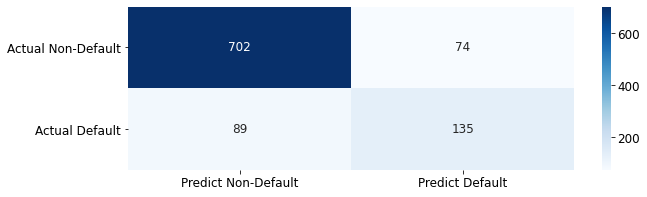

In [363]:
score(predictor.predict_many_from_df(xtest), ytest)

In [364]:
sample = dict(xtest.iloc[0])

In [365]:
predictor.predict(sample)

True

In [366]:
raw_data = pd.read_csv('../dataset/data.csv')

In [367]:
predictor.predict(dict(raw_data.iloc[0]), engineer_features=True)

False

In [ ]:
predictor.explain_prediction(sample, engineer_features=False)

# Pickled Model

In [370]:
import dill as pickle

In [371]:
pickle.dump(predictor, open('predictor.pkl', 'wb'))